In [1]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

videos = list(Path("../data/videos").glob("*.mp4"))

2345it [00:03, 662.23it/s]


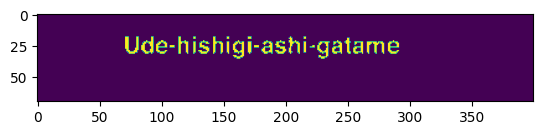

In [27]:
from tqdm import tqdm


def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def get_subset(img, threshold=0.9):
    img = img[630:700, :400]

    # lets binarize based on closeness to white
    t = 255 * threshold
    img = cv2.inRange(img, (t, t, t), (255, 255, 255), img)
    img = cv2.bitwise_not(img)

    # lets also flood fill the background with black from corners
    n = img.shape[0]
    corners = [(0, 0), (0, n - 1), (n - 1, 0), (n - 1, n - 1)]
    for corner in corners:
        cv2.floodFill(img, None, corner, 0)

    # erode the text
    # kernel = np.ones((2, 2), np.uint8)
    # img = cv2.erode(img, kernel, iterations=1)
    # img = cv2.dilate(img, kernel, iterations=1)
    return img


video = [v for v in videos if "kansetsu-waza" in v.name.lower()][0]
cap = cv2.VideoCapture(video.as_posix())
frames = []
for frame in tqdm(get_frames(cap)):
    subset = get_subset(frame, threshold=0.7)
    frames.append(subset)
    # if len(frames) > 25*15: break

plt.imshow(frames[len(frames) // 2])
plt.show()

# write the frames to disk as a video
frame = frames[0]
writer = cv2.VideoWriter(
    "../data/tmp/frames.mp4",
    cv2.VideoWriter_fourcc(*"avc1"),
    120,
    (frame.shape[1], frame.shape[0]),
)
for i, frame in enumerate(frames):
    # grayscale to color
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    writer.write(frame)
writer.release()

0it [00:00, ?it/s]

2345it [00:03, 704.13it/s]


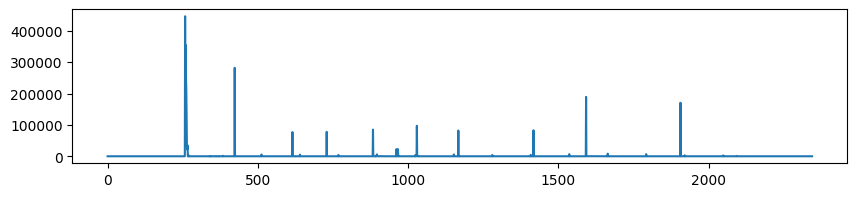

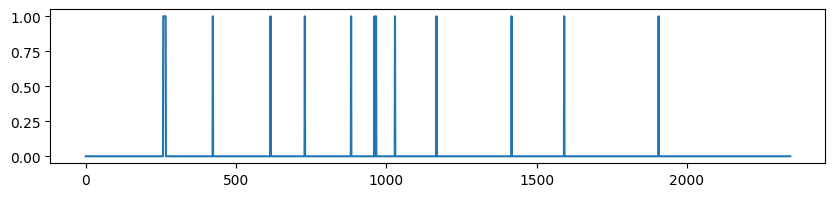

[[ 266  422]
 [ 423  614]
 [ 615  728]
 [ 729  882]
 [ 883 1028]
 [1029 1166]
 [1167 1416]
 [1417 1591]
 [1592 1905]
 [1906 2092]]
[[10.64 16.88]
 [16.92 24.56]
 [24.6  29.12]
 [29.16 35.28]
 [35.32 41.12]
 [41.16 46.64]
 [46.68 56.64]
 [56.68 63.64]
 [63.68 76.2 ]
 [76.24 83.68]]


In [54]:
def calculate_intervals(video, threshold=0.9):
    cap = cv2.VideoCapture(video.as_posix())
    frames = []
    for frame in tqdm(get_frames(cap)):
        subset = get_subset(frame, threshold)
        frames.append(subset)

    diffs = [0]
    for i in range(1, len(frames)):
        a, b = frames[i], frames[i - 1]
        score = np.sum(np.abs(a - b))
        diffs.append(score)
    diffs = np.array(diffs)
    scores = (diffs - np.mean(diffs)) / np.std(diffs)

    nonzero = np.where(diffs > 0)[0].tolist()
    points = [nonzero[0]] + np.where(scores > 1)[0].tolist() + [nonzero[-1]]
    intervals = []
    for i in range(1, len(points)):
        a, b = points[i - 1], points[i]
        if b - a > 25:
            intervals.append((a, b - 1))

    # custom logic, because feet get into the subtitle
    if "koshi-waza" in video.stem.lower() and threshold == 0.70:
        # NOTE!!! this is only valid for threshold=0.70, I hate this logic...
        # merge the interval that (493, 552), (.., 570), (571, 664)
        intervals += [(493, 570)]
        intervals = sorted(intervals, key=lambda x: x[0])
        intervals = [iv for iv in intervals if not (iv[1] == 552)]

    if "kansetsu-waza" in video.stem.lower():
        # merge the interval that  [ 883  960][ 966 1028]
        intervals += [(883, 1028)]
        intervals = sorted(intervals, key=lambda x: x[0])
        intervals = [iv for iv in intervals if not (iv[1] == 960 or iv[0] == 966)]

    return intervals, (diffs, scores)


intervals, (diffs, scores) = calculate_intervals(video, 0.9)
plt.figure(figsize=(10, 2))
plt.plot(diffs)
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(scores > 1)
plt.show()
print(np.array(intervals))
print(np.array(intervals) / 25)

In [55]:
# create the folder
def segment(video, dest_root, intervals):
    stem = video.stem.split()[-1].lower()
    dest_dir = dest_root / stem
    dest_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving clips to {dest_dir}")

    cap = cv2.VideoCapture(video.as_posix())
    writer = None
    interval_idx = 0
    for i, frame in tqdm(enumerate(get_frames(cap))):
        if interval_idx >= len(intervals):
            break
        if writer is None:
            filename = dest_dir / f"{stem}_{interval_idx:02d}.mp4"
            # print(f"Creating {filename}")
            writer = cv2.VideoWriter(
                filename.as_posix(),
                cv2.VideoWriter_fourcc(*"avc1"),
                25,
                (frame.shape[1], frame.shape[0]),
            )
        s, e = intervals[interval_idx]
        if i < s:
            continue
        if i > e:
            interval_idx += 1
            writer.release()
            writer = None
            continue
        writer.write(frame)


dest_root = Path("../data/tmp/clips")
mapping = {"koshi-waza": 0.7}
video = [v for v in videos if "koshi-waza" in v.name.lower()][0]
name = video.stem.split()[-1].lower()
intervals, _ = calculate_intervals(video, mapping.get(name, 0.9))
segment(video, dest_root, intervals)

1426it [00:02, 680.49it/s]


Saving clips to ../data/tmp/clips/koshi-waza


1161it [00:07, 157.09it/s]


2180it [00:03, 683.30it/s]0<?, ?it/s]


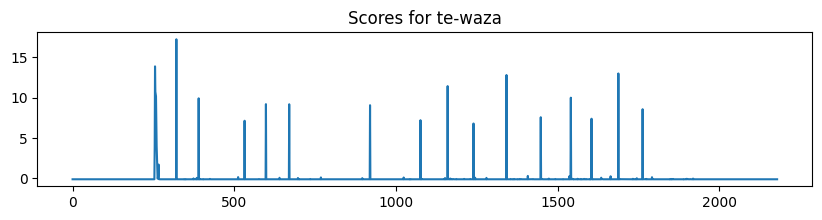

3273it [00:04, 699.00it/s]3<00:23,  3.30s/it]


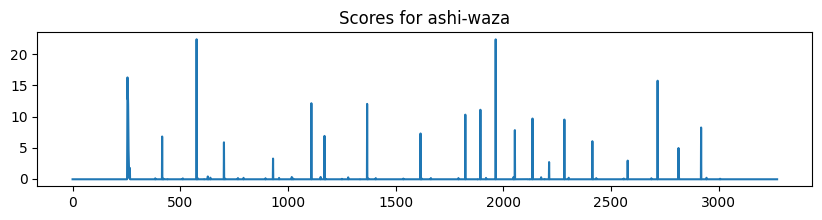

2375it [00:03, 687.61it/s]8<00:25,  4.18s/it]


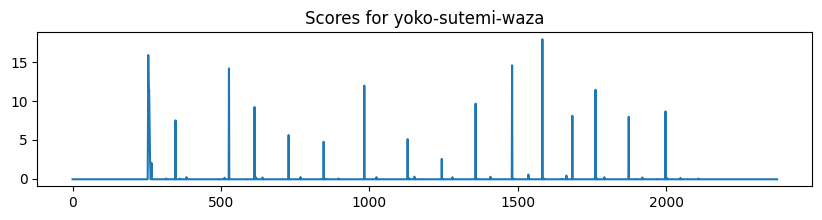

6302it [00:08, 702.43it/s]1<00:19,  3.89s/it]


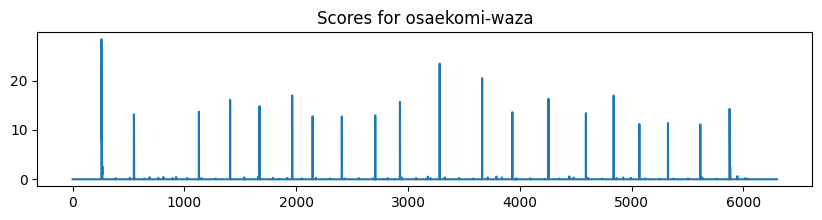

1083it [00:01, 758.24it/s]0<00:23,  5.96s/it]


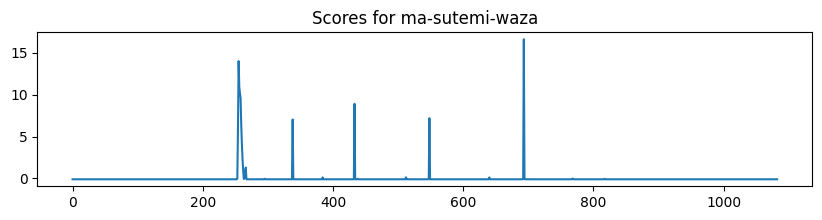

5314it [00:07, 702.53it/s]2<00:13,  4.35s/it]


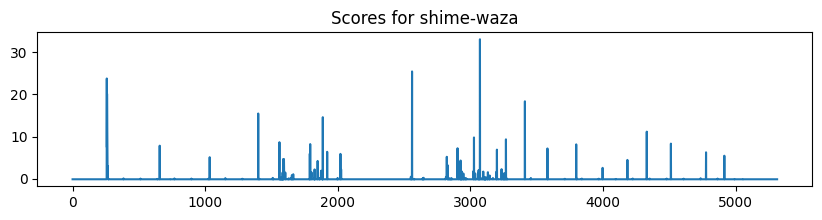

1426it [00:02, 709.93it/s]0<00:11,  5.50s/it]


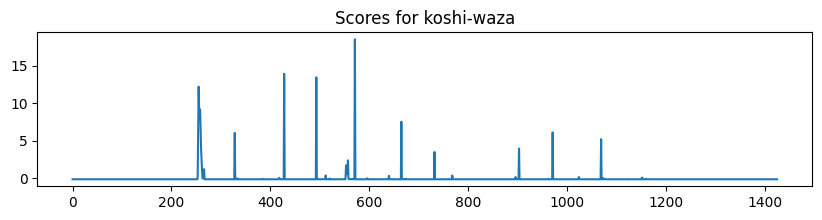

2345it [00:03, 706.80it/s]2<00:04,  4.39s/it]


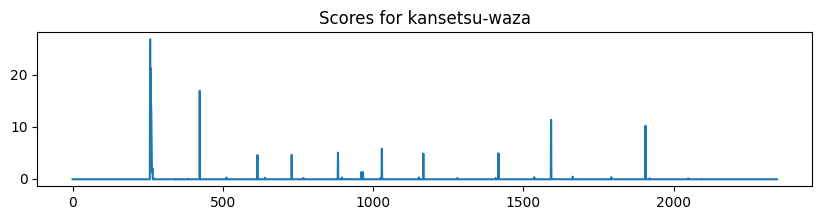

100%|██████████| 8/8 [00:35<00:00,  4.44s/it]
2180it [00:02, 747.60it/s]0<?, ?it/s]


Saving clips to ../data/tmp/clips/te-waza


1920it [00:12, 151.41it/s]
3273it [00:04, 744.68it/s]5<01:49, 15.64s/it]


Saving clips to ../data/tmp/clips/ashi-waza


3008it [00:23, 126.43it/s]
2375it [00:03, 681.91it/s]3<02:18, 23.07s/it]


Saving clips to ../data/tmp/clips/yoko-sutemi-waza


2110it [00:15, 133.07it/s]
6302it [00:09, 691.57it/s]3<01:46, 21.39s/it]


Saving clips to ../data/tmp/clips/osaekomi-waza


6044it [01:05, 92.43it/s]
1083it [00:01, 555.38it/s]7<02:49, 42.40s/it]


Saving clips to ../data/tmp/clips/ma-sutemi-waza


818it [00:05, 143.16it/s]
5314it [00:09, 576.14it/s]5<01:29, 29.89s/it]


Saving clips to ../data/tmp/clips/shime-waza


5056it [00:39, 128.21it/s]
1426it [00:02, 580.99it/s]4<01:12, 36.31s/it]


Saving clips to ../data/tmp/clips/koshi-waza


1161it [00:08, 134.08it/s]
2345it [00:03, 597.82it/s]5<00:28, 28.09s/it]


Saving clips to ../data/tmp/clips/kansetsu-waza


2094it [00:18, 111.61it/s]
100%|██████████| 8/8 [03:48<00:00, 28.54s/it]


In [52]:
dest_root = Path("../data/tmp/clips")
mapping = {"koshi-waza": 0.7}
for video in tqdm(videos):
    name = video.stem.split()[-1].lower()
    intervals, (diffs, scores) = calculate_intervals(
        video, threshold=mapping.get(name, 0.9)
    )
    # a plot of scores, short but wide
    plt.figure(figsize=(10, 2))
    plt.plot(scores)
    plt.title(f"Scores for {name}")
    plt.show()

for video in tqdm(videos):
    name = video.stem.split()[-1].lower()
    intervals, (diffs, scores) = calculate_intervals(
        video, threshold=mapping.get(name, 0.9)
    )
    segment(video, dest_root, intervals)

In [56]:
! ls -lhR ../data/tmp/clips/

total 0
drwxr-xr-x  23 anthony  staff   736B Aug 20 20:19 ashi-waza
drwxr-xr-x  12 anthony  staff   384B Aug 20 20:22 kansetsu-waza
drwxr-xr-x  12 anthony  staff   384B Aug 20 22:27 koshi-waza
drwxr-xr-x   7 anthony  staff   224B Aug 20 20:21 ma-sutemi-waza
drwxr-xr-x  22 anthony  staff   704B Aug 20 20:20 osaekomi-waza
drwxr-xr-x  28 anthony  staff   896B Aug 20 20:21 shime-waza
drwxr-xr-x  18 anthony  staff   576B Aug 20 20:18 te-waza
drwxr-xr-x  18 anthony  staff   576B Aug 20 20:19 yoko-sutemi-waza

../data/tmp/clips//ashi-waza:
total 45040
-rw-r--r--  1 anthony  staff   967K Aug 20 20:18 ashi-waza_00.mp4
-rw-r--r--  1 anthony  staff   1.0M Aug 20 20:18 ashi-waza_01.mp4
-rw-r--r--  1 anthony  staff   925K Aug 20 20:19 ashi-waza_02.mp4
-rw-r--r--  1 anthony  staff   1.4M Aug 20 20:19 ashi-waza_03.mp4
-rw-r--r--  1 anthony  staff   1.3M Aug 20 20:19 ashi-waza_04.mp4
-rw-r--r--  1 anthony  staff   280K Aug 20 20:19 ashi-waza_05.mp4
-rw-r--r--  1 anthony  staff   1.2M Aug 20 20:19 ashi